<h1>Pronóstico de demanda de los clientes</h1>

In [1]:
# Importación de las librerías
import numpy as np
import pandas as pd
from keras.models import load_model
import modulo_conn_sql as mcq
import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from io import BytesIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pickle import dump, load

#Metodos auxiliares
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

In [28]:
"""
DESCRIPCION PARAMETROS

timesteps: mermoria corto plazo
un: numero de neuronas
do: coeficiente de olvido
flag_do: activar o desactivar dropout
ep: numero de ciclos
ly: numero de capas ocultas

"""

def entrenar(dataset, fecha_split, timesteps, un, do, flag_do, ep, ly):

    #pre-procesamiento de los datos
    dataset_array = dataset.iloc[:, 1:8].values

    #Defino dataset de entrenamiento y dataset de test
    dataset_train = dataset[dataset['FechaEntrega'] < fecha_split]
    training_set = dataset_train.iloc[:, 1:8].values

    dataset_test = dataset[dataset['FechaEntrega'] >= fecha_split]
    test_set = dataset_test.iloc[:, 1:8].values

    #Escalado de caracteristicas
    sc = MinMaxScaler(feature_range = (0,1))
    dataset_array_scaled = sc.fit_transform(dataset_array)
    training_set_scaled = sc.transform(training_set)
    test_set_scaled = sc.transform(test_set)

    #ESTRUCTURA DE LA RED NUERONAL RECURRENTE

    #defino un array por cada variable predictora y un array para hacer la estructura de tensor
    X_train_material = []
    X_train_DiaSemana = []
    X_train_SemanaRelativa = []
    X_train_SemanaMes = []
    X_train_Mes = []
    X_train_Year = []
    ####X_train_Edad = []
    X_train = []

    y_train = []

    for i in range (timesteps, len(training_set)):

        #columna 0 -> Cantidad Material
        X_train_material.append(training_set_scaled[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_train_DiaSemana.append(training_set_scaled[i-timesteps:i, 1])

        #columna 2 -> SemanaRelativa
        X_train_SemanaRelativa.append(training_set_scaled[i-timesteps:i, 2])

        #columna 3 -> SemanaMEs
        X_train_SemanaMes.append(training_set_scaled[i-timesteps:i, 3])

        #columna 4 -> Mes
        X_train_Mes.append(training_set_scaled[i-timesteps:i, 4])

        #columna 5-> Año
        X_train_Year.append(training_set_scaled[i-timesteps:i, 5])
        
        #columna 6-> Edad
        #####X_train_Edad.append(training_set_scaled[i-timesteps:i, 6])

        y_train.append(training_set_scaled[i, 0])

    #se convierten los array en objetos numpy
    X_train_material = np.array(X_train_material)
    X_train_DiaSemana = np.array(X_train_DiaSemana)
    X_train_SemanaRelativa = np.array(X_train_SemanaRelativa)
    X_train_SemanaMes = np.array(X_train_SemanaMes)
    X_train_Mes = np.array(X_train_Mes)
    X_train_Year = np.array(X_train_Year)
    #####X_train_Edad = np.array(X_train_Edad)
    y_train = np.array(y_train)

    #se agrega una nueva dimension a las variables
    X_train_material = np.reshape(X_train_material, (X_train_material.shape[0], X_train_material.shape[1], 1))
    X_train_DiaSemana = np.reshape(X_train_DiaSemana, (X_train_DiaSemana.shape[0], X_train_DiaSemana.shape[1], 1))
    X_train_SemanaRelativa = np.reshape(X_train_SemanaRelativa, (X_train_SemanaRelativa.shape[0], X_train_SemanaRelativa.shape[1], 1))
    X_train_SemanaMes = np.reshape(X_train_SemanaMes, (X_train_SemanaMes.shape[0], X_train_SemanaMes.shape[1], 1))
    X_train_Mes = np.reshape(X_train_Mes, (X_train_Mes.shape[0], X_train_Mes.shape[1], 1))
    X_train_Year = np.reshape(X_train_Year, (X_train_Year.shape[0], X_train_Year.shape[1], 1))
    #####X_train_Edad = np.reshape(X_train_Edad, (X_train_Edad.shape[0], X_train_Edad.shape[1], 1))

    #se crea la estructura de datos que se leva a pasar al regresor
    X_train = X_train_material
    X_train = np.append(X_train, (X_train_DiaSemana), axis=2)
    X_train = np.append(X_train, (X_train_SemanaRelativa), axis=2)
    X_train = np.append(X_train, (X_train_SemanaMes), axis=2)
    X_train = np.append(X_train, (X_train_Mes), axis=2)
    X_train = np.append(X_train, (X_train_Year), axis=2)
   ##### X_train = np.append(X_train, (X_train_Edad), axis=2)


    #inicializacion del regresor
    regressor = Sequential()

    if (ly == 0):
        #añadir la primera capa de LSTM y la regularizacion por dropout
        regressor.add(LSTM(units=un, input_shape= (X_train.shape[1], X_train.shape[2])))
        if(flag_do): 
            regressor.add(Dropout(do))

    elif (ly > 1):
        for k in range(0, ly):
            #añadir la primera capa de LSTM y la regularizacion por dropout
            regressor.add(LSTM(units=un, return_sequences = True, input_shape= (X_train.shape[1], X_train.shape[2])))
            if(flag_do): 
                regressor.add(Dropout(do))
        #anadir penultima capa
        regressor.add(LSTM(units=un))
        if(flag_do): 
            regressor.add(Dropout(do))

    elif (ly == 1):
        #añadir la primera capa de LSTM y la regularizacion por dropout
        regressor.add(LSTM(units=un, return_sequences = True, input_shape= (X_train.shape[1], X_train.shape[2])))
        if(flag_do): 
            regressor.add(Dropout(do))
        #anadir penultima capa
        regressor.add(LSTM(units=un))
        if(flag_do): 
            regressor.add(Dropout(do))


    #regressor.add(LSTM(units=un, input_shape= (X_train.shape[1], X_train.shape[2])))

    #anadir capa de salida        
    regressor.add(Dense(units=1))

    #compilar la RNR
    regressor.compile(optimizer = 'adam', loss='mean_squared_error')

    #ajustar la RNR al conjunto de entrenamiento
    regressor.fit(X_train, y_train, epochs = ep, batch_size = 512, verbose = 1)
    
    return regressor




def testear(dataset, fecha_split, regressor, timesteps):
    #TEST DE LA RNR

    #pre-procesamiento de los datos
    dataset_array = dataset.iloc[:, 1:8].values
    
    dataset_train = dataset[dataset['FechaEntrega'] < fecha_split]
    training_set = dataset_train.iloc[:, 1:8].values

    dataset_test = dataset[dataset['FechaEntrega'] >= fecha_split]
    test_set = dataset_test.iloc[:, 1:8].values

    #Escalado de caracteristicas
    sc = MinMaxScaler(feature_range = (0,1))
    dataset_array_scaled = sc.fit_transform(dataset_array)
    training_set_scaled = sc.transform(training_set)
    test_set_scaled = sc.transform(test_set)


    #los inputs van a ser los ultimos Timesteps dias del trainig set, para predecir el primer dia
    inputs = training_set_scaled[len(training_set_scaled)- timesteps:]

    for j in range( 0, test_set_scaled.shape[0] ):
        X_test = []
        X_test_material = []
        X_test_DiaSemana = []
        X_test_SemanaRelativa = []
        X_test_SemanaMes = []
        X_test_Mes = []
        X_test_Year = []
        #####X_test_Edad = []


        for i in range (timesteps, inputs.shape[0] + 1):

            #columna 0 -> cantidad de material
            X_test_material.append(inputs[i-timesteps:i, 0])

            #columna 1 -> Dia Semana
            X_test_DiaSemana.append(inputs[i-timesteps:i, 1])

            #columna 2 -> Semana Relativo
            X_test_SemanaRelativa.append(inputs[i-timesteps:i, 2])

            #columna 3 -> SemanaMes
            X_test_SemanaMes.append(inputs[i-timesteps:i, 3])

            #columna 4 -> Mes
            X_test_Mes.append(inputs[i-timesteps:i, 4])

            #columna 5 -> Año
            X_test_Year.append(inputs[i-timesteps:i, 5])
            
            #columna 6 -> Edad
            #####X_test_Edad.append(inputs[i-timesteps:i, 6])



        #se convierten los array en objetos numpy
        X_test_material = np.array(X_test_material)
        X_test_DiaSemana = np.array(X_test_DiaSemana)
        X_test_SemanaRelativa = np.array(X_test_SemanaRelativa)
        X_test_SemanaMes = np.array(X_test_SemanaMes)
        X_test_Mes = np.array(X_test_Mes)
        X_test_Year = np.array(X_test_Year)
        #####X_test_Edad = np.array(X_test_Edad)

        #se agrega una nueva dimension a las variables
        X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
        X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
        X_test_SemanaRelativa = np.reshape(X_test_SemanaRelativa, (X_test_SemanaRelativa.shape[0], X_test_SemanaRelativa.shape[1], 1 ))
        X_test_SemanaMes = np.reshape(X_test_SemanaMes, (X_test_SemanaMes.shape[0], X_test_SemanaMes.shape[1], 1 ))
        X_test_Mes = np.reshape(X_test_Mes, (X_test_Mes.shape[0], X_test_Mes.shape[1], 1 ))
        X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))
       ##### X_test_Edad = np.reshape(X_test_Edad, (X_test_Edad.shape[0], X_test_Edad.shape[1], 1 ))

        #se crea la estrutura de datos que se lev va a pasar al regresor
        X_test = X_test_material
        X_test = np.append(X_test, (X_test_DiaSemana), axis=2)
        X_test = np.append(X_test, (X_test_SemanaRelativa), axis=2)
        X_test = np.append(X_test, (X_test_SemanaMes), axis=2)
        X_test = np.append(X_test, (X_test_Mes), axis=2)
        X_test = np.append(X_test, (X_test_Year), axis=2)
        #####X_test = np.append(X_test, (X_test_Edad), axis=2)

        #ejecutar la prediccion
        prediction = regressor.predict(X_test)

        #a la prediccion le agrego las demas variables predictoras
        prediction = np.append(prediction, (test_set_scaled[:len(prediction), 1: ]), axis=1 )

        inputs = training_set_scaled[len(training_set_scaled) - timesteps:]

        inputs = np.append(inputs, (prediction), axis=0)

    prediction = sc.inverse_transform(prediction)

    # Junto real y resultado en un dataframe para evaluar su asertividad
    df_real_prediccion = pd.DataFrame({'FechaEntrega':dataset_test['FechaEntrega'], 'Real':test_set[:,0], 'Forecast':prediction[:,0]})
    df_real_prediccion['FechaEntrega'] = pd.to_datetime(df_real_prediccion['FechaEntrega'])
    df_real_prediccion['Real'] = df_real_prediccion['Real'].astype(float)
    df_real_prediccion['Forecast'] = df_real_prediccion['Forecast'].astype(float)
    #calculo de la desviacion diaria del forecast
    df_real_prediccion['APE'] = (((df_real_prediccion['Real'] - df_real_prediccion['Forecast']).abs())/df_real_prediccion['Real']).fillna(0)

    return df_real_prediccion[df_real_prediccion['Real'] > 0]

In [4]:
#Dataset de los despachos
#Variables 
pais='Colombia'
years = [2021]
for i,var in enumerate(years):
    if i == 0:
        df = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        df = df.fillna(value=np.nan)
        df['year_month'] = df.FechaEntrega.dt.to_period('M')
    else:
        temp = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        temp = temp.fillna(value=np.nan)
        temp['year_month'] = temp.FechaEntrega.dt.to_period('M')
        
        df = pd.concat([df, temp ])
        
# VARIABLES AUXILIARES

# dataset calendario
df_calendario_principal = querySQL( "select * from SCAC_AT3_DiasHabilesFuente where pais = (?)" , (pais) )
df_calendario_principal['Fecha de entrega'] = pd.to_datetime(df_calendario_principal['Fecha de entrega'])

# edad del volumen 
df_edad = querySQL( "{CALL SCAC_AP13_EdadVolumen (?,?,?)}" , (pais, df['FechaEntrega'].min().strftime("%Y-%m-%d"), pd.to_datetime("now").strftime("%Y-%m-%d") ))
df_edad['Edad'] = pd.to_datetime(df_edad['Fecha']) - pd.to_datetime(df_edad['PrimerConsumo'])
df_edad['Edad'] = df_edad['Edad'] / np.timedelta64(1,'D')
df_edad['year_month'] = df_edad.Fecha.dt.to_period('M')

<h2> Analizando un poco los datos </h2>

Text(0, 0.5, 'Repeticiones')

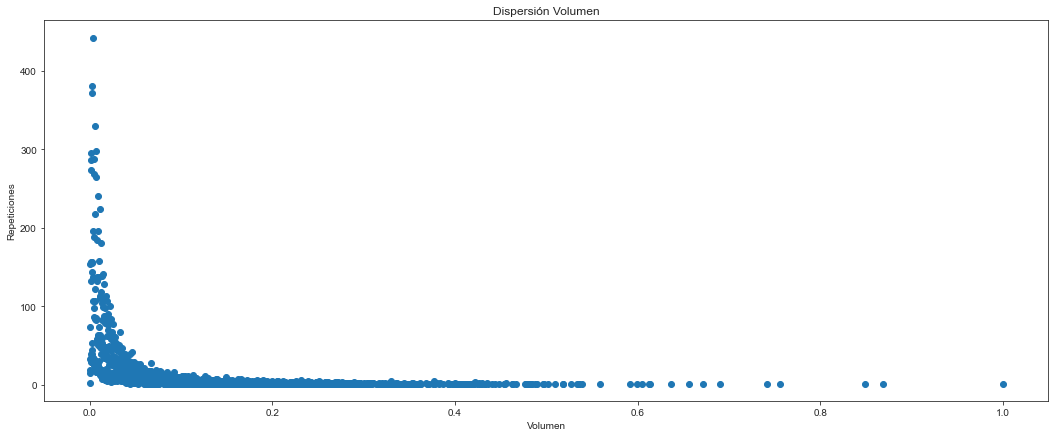

In [196]:
df_obras = df.groupby(['year_month', 'Obra']).agg({'VolPartida': sum}).reset_index()
df_obras = df_obras.groupby(['VolPartida'])['VolPartida'].agg(['count']).reset_index()
df_obras = df_obras[df_obras['count']>1]
df_obras = df_obras.reset_index()
df_obras = df_obras[['VolPartida', 'count']]
sc = MinMaxScaler(feature_range = (0,1))
array_vol = df_obras.iloc[:, 0:1]
array_vol_scaled = sc.fit_transform(array_vol)
df_result = pd.DataFrame({'VolEscalado':array_vol_scaled[:,0] })
df_result2 = pd.concat([df_result, df_obras], axis = 1)
 #grafico la dispersión de los datos
plt.figure(figsize=(18,7))
plt.scatter(df_result2['VolEscalado'], df_obras['count'])
plt.title("Dispersión Volumen")
plt.xlabel("Volumen")
plt.ylabel("Repeticiones")

<h2> Forecast </h2>

In [12]:
#Variables del Forecast

#mermoria corto plazo
######################timesteps = 15
#numero de neuronas
######################un = 180
#coeficiente de olvido
######################do = 0.05
#activar o desactivar dropout
#####################flag_do = False
#numero de ciclos
#ep = 10
#numero de capas ocultas
#ly = 1

#cliente target
cliente = '50119577'
obra = '66883698'

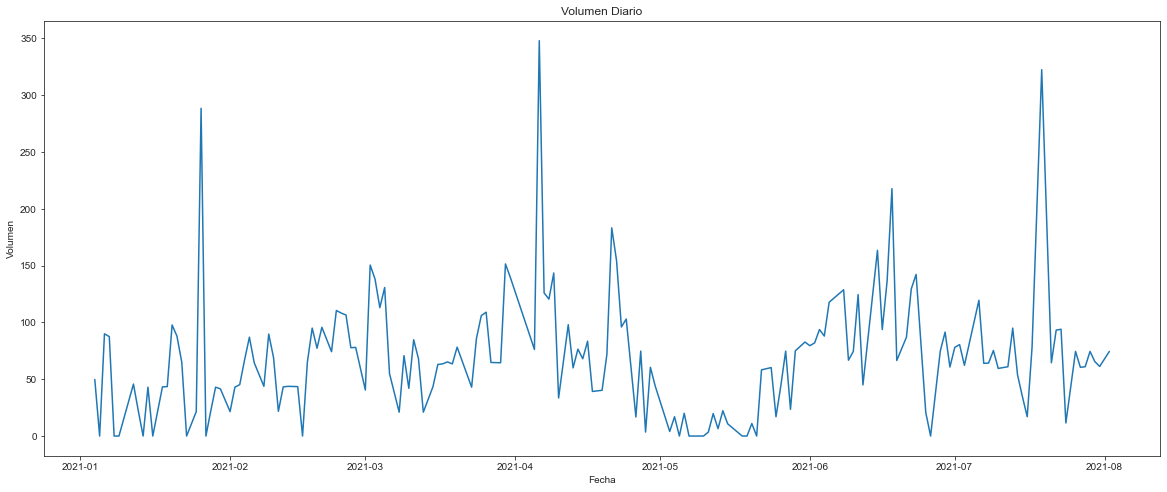

In [20]:
#Obtención de los datos
#Fuente: SQL Server

dataset = df[df['Obra'] == obra].groupby(['FechaEntrega']).agg({'VolPartida': sum}).reset_index()
dataset['FechaEntrega'] = pd.to_datetime(dataset['FechaEntrega'])
dataset['year-month'] = dataset.FechaEntrega.dt.to_period('M')
#filtro las fechas del calendario
df_calendario = df_calendario_principal[(df_calendario_principal['Fecha de entrega'] >= dataset['FechaEntrega'].min()) & (df_calendario_principal['Fecha de entrega'] <  dataset['FechaEntrega'].max() ) & (df_calendario_principal['Días_Operativos'] == 1)]

# obtengo la edad mensual de cada obra
df_edad_obra = df_edad[df_edad['Obra']==obra]

#hago un join de la variable principal y la auxiliares
dataset = pd.merge(dataset, df_edad_obra, left_on='FechaEntrega', right_on='Fecha',  how= 'left')
dataset = pd.merge(df_calendario, dataset, left_on='Fecha de entrega', right_on= 'FechaEntrega', how = 'left')#.fillna(0)
#####dataset = dataset[['Fecha de entrega','VolPartida', 'Dia_Semana', 'Semana_relativa', 'Semanas_mes', 'Mes', 'Año', 'Edad']].fillna(0)
dataset = dataset[['Fecha de entrega','VolPartida', 'Dia_Semana', 'Semana_relativa', 'Semanas_mes', 'Mes', 'Año']].fillna(0)


dataset.rename(columns = {'Fecha de entrega' : 'FechaEntrega'}, inplace = True)

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
rotation = 45
sns.lineplot(x = dataset['FechaEntrega'], y = dataset['VolPartida'])
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.title("Volumen Diario")

plt.show()

<h1>Evaluación del mejor regresor</h1>

In [14]:
"""
#mermoria corto plazo
timesteps = 15
#numero de neuronas
un = 180
#coeficiente de olvido
do = 0.05
#activar o desactivar dropout
flag_do = False
#numero de ciclos
ep = 10
#numero de capas ocultas
ly = 1

"""

timesteps_array = [20]
un_array = [200]
do_array = [0.1]
ly_array = [5]

for i, var_i in enumerate(timesteps_array):
    for j, var_j in enumerate(un_array):
        for k, var_k in enumerate(do_array):
            for n, var_n in enumerate(ly_array):
                
                r = entrenar(dataset, '2021-06-30', var_i, var_j, var_k, True, 520, var_n)
                df_1 = testear(dataset, '2021-02-01', r, var_i )
                df_1['timesteps'] = var_i
                df_1['neuronas'] = var_j
                df_1['dropout'] = var_k
                df_1['capas_ocultas'] = var_n
                
                if( i == 0 & j == 0 & k == 0 & n == 0 ):
                    df_result = df_1
                else:
                    df_result = pd.concat([df_result, df_1])

df_result['year-month'] = df_result['FechaEntrega'].dt.to_period('M')
df_export = df_result.groupby(['timesteps', 'neuronas', 'dropout', 'capas_ocultas', 'year-month']).agg({'APE':'mean', 'Real':sum, 'Forecast':sum}).reset_index()
df_export['Desviacion_year-month'] = (df_export['Real'] - df_export['Forecast']).abs()

#exportar a excel
writer = pd.ExcelWriter("../datos/accuracyRNR" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
df_export.to_excel( writer, sheet_name="resultados" )
writer.save()

<h1>Guardar regresor y escalador para futuros usos</h1>

In [32]:
#Escalado de caracteristicas
dataset_array = dataset.iloc[:, 1:7].values
sc = MinMaxScaler(feature_range = (0,1))
dataset_array_scaled = sc.fit_transform(dataset_array)
#guardar escalador
dump(sc, open("../datos/escalador_" + obra + ".kpl", 'wb'))


#se toma el mejor regresor
regressor = entrenar(dataset, '2021-07-31', 60, 180, 0.1 , True, 600, 4)
#guardar regresor
regressor.save("../datos/regresor_" + obra + ".h5")

Epoch 1/600
1/1 [==============================] - 16s 16s/step - loss: 0.0708
Epoch 2/600
1/1 [==============================] - 2s 2s/step - loss: 0.0387
Epoch 3/600
1/1 [==============================] - 2s 2s/step - loss: 0.0439
Epoch 4/600
1/1 [==============================] - 2s 2s/step - loss: 0.0376
Epoch 5/600
1/1 [==============================] - 2s 2s/step - loss: 0.0284
Epoch 6/600
1/1 [==============================] - 2s 2s/step - loss: 0.0290
Epoch 7/600
1/1 [==============================] - 2s 2s/step - loss: 0.0310
Epoch 8/600
1/1 [==============================] - 2s 2s/step - loss: 0.0267
Epoch 9/600
1/1 [==============================] - 2s 2s/step - loss: 0.0281
Epoch 10/600
1/1 [==============================] - 2s 2s/step - loss: 0.0289
Epoch 11/600
1/1 [==============================] - 2s 2s/step - loss: 0.0284
Epoch 12/600
1/1 [==============================] - 2s 2s/step - loss: 0.0259
Epoch 13/600
1/1 [==============================] - 2s 2s/step - loss: 

1/1 [==============================] - 2s 2s/step - loss: 0.0178
Epoch 107/600
1/1 [==============================] - 2s 2s/step - loss: 0.0171
Epoch 108/600
1/1 [==============================] - 2s 2s/step - loss: 0.0176
Epoch 109/600
1/1 [==============================] - 2s 2s/step - loss: 0.0177
Epoch 110/600
1/1 [==============================] - 2s 2s/step - loss: 0.0168
Epoch 111/600
1/1 [==============================] - 2s 2s/step - loss: 0.0175
Epoch 112/600
1/1 [==============================] - 2s 2s/step - loss: 0.0170
Epoch 113/600
1/1 [==============================] - 2s 2s/step - loss: 0.0180
Epoch 114/600
1/1 [==============================] - 2s 2s/step - loss: 0.0170
Epoch 115/600
1/1 [==============================] - 2s 2s/step - loss: 0.0172
Epoch 116/600
1/1 [==============================] - 2s 2s/step - loss: 0.0169
Epoch 117/600
1/1 [==============================] - 2s 2s/step - loss: 0.0168
Epoch 118/600
1/1 [==============================] - 2s 2s/step - 

1/1 [==============================] - 2s 2s/step - loss: 0.0271
Epoch 210/600
1/1 [==============================] - 2s 2s/step - loss: 0.0271
Epoch 211/600
1/1 [==============================] - 3s 3s/step - loss: 0.0255
Epoch 212/600
1/1 [==============================] - 2s 2s/step - loss: 0.0279
Epoch 213/600
1/1 [==============================] - 3s 3s/step - loss: 0.0274
Epoch 214/600
1/1 [==============================] - 2s 2s/step - loss: 0.0250
Epoch 215/600
1/1 [==============================] - 2s 2s/step - loss: 0.0259
Epoch 216/600
1/1 [==============================] - 2s 2s/step - loss: 0.0264
Epoch 217/600
1/1 [==============================] - 2s 2s/step - loss: 0.0245
Epoch 218/600
1/1 [==============================] - 2s 2s/step - loss: 0.0247
Epoch 219/600
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 220/600
1/1 [==============================] - 3s 3s/step - loss: 0.0249
Epoch 221/600
1/1 [==============================] - 5s 5s/step - 

1/1 [==============================] - 4s 4s/step - loss: 0.0161
Epoch 313/600
1/1 [==============================] - 3s 3s/step - loss: 0.0151
Epoch 314/600
1/1 [==============================] - 3s 3s/step - loss: 0.0164
Epoch 315/600
1/1 [==============================] - 3s 3s/step - loss: 0.0156
Epoch 316/600
1/1 [==============================] - 3s 3s/step - loss: 0.0157
Epoch 317/600
1/1 [==============================] - 3s 3s/step - loss: 0.0143
Epoch 318/600
1/1 [==============================] - 2s 2s/step - loss: 0.0175
Epoch 319/600
1/1 [==============================] - 3s 3s/step - loss: 0.0153
Epoch 320/600
1/1 [==============================] - 2s 2s/step - loss: 0.0157
Epoch 321/600
1/1 [==============================] - 2s 2s/step - loss: 0.0156
Epoch 322/600
1/1 [==============================] - 2s 2s/step - loss: 0.0157
Epoch 323/600
1/1 [==============================] - 2s 2s/step - loss: 0.0168
Epoch 324/600
1/1 [==============================] - 3s 3s/step - 

1/1 [==============================] - 2s 2s/step - loss: 0.0135
Epoch 416/600
1/1 [==============================] - 2s 2s/step - loss: 0.0140
Epoch 417/600
1/1 [==============================] - 2s 2s/step - loss: 0.0138
Epoch 418/600
1/1 [==============================] - 2s 2s/step - loss: 0.0123
Epoch 419/600
1/1 [==============================] - 2s 2s/step - loss: 0.0139
Epoch 420/600
1/1 [==============================] - 2s 2s/step - loss: 0.0130
Epoch 421/600
1/1 [==============================] - 2s 2s/step - loss: 0.0131
Epoch 422/600
1/1 [==============================] - 2s 2s/step - loss: 0.0134
Epoch 423/600
1/1 [==============================] - 2s 2s/step - loss: 0.0132
Epoch 424/600
1/1 [==============================] - 2s 2s/step - loss: 0.0131
Epoch 425/600
1/1 [==============================] - 2s 2s/step - loss: 0.0119
Epoch 426/600
1/1 [==============================] - 2s 2s/step - loss: 0.0131
Epoch 427/600
1/1 [==============================] - 2s 2s/step - 

1/1 [==============================] - 3s 3s/step - loss: 0.0143
Epoch 519/600
1/1 [==============================] - 2s 2s/step - loss: 0.0124
Epoch 520/600
1/1 [==============================] - 2s 2s/step - loss: 0.0133
Epoch 521/600
1/1 [==============================] - 2s 2s/step - loss: 0.0133
Epoch 522/600
1/1 [==============================] - 3s 3s/step - loss: 0.0124
Epoch 523/600
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 524/600
1/1 [==============================] - 3s 3s/step - loss: 0.0123
Epoch 525/600
1/1 [==============================] - 3s 3s/step - loss: 0.0124
Epoch 526/600
1/1 [==============================] - 3s 3s/step - loss: 0.0120
Epoch 527/600
1/1 [==============================] - 3s 3s/step - loss: 0.0112
Epoch 528/600
1/1 [==============================] - 2s 2s/step - loss: 0.0122
Epoch 529/600
1/1 [==============================] - 3s 3s/step - loss: 0.0127
Epoch 530/600
1/1 [==============================] - 2s 2s/step - 

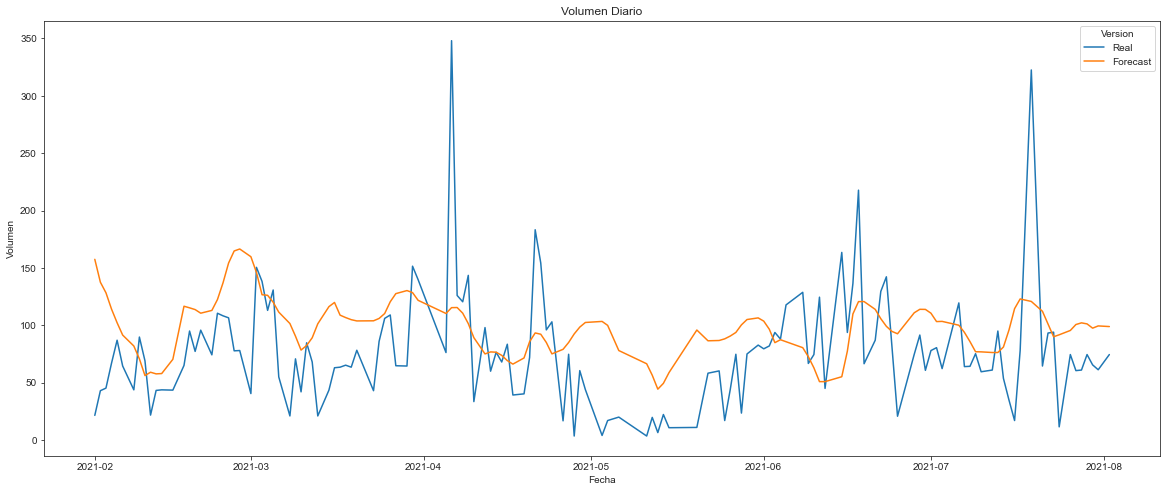

In [34]:
df_best_regressor = testear(dataset, '2021-02-01', regressor, 20 )

#Grafica de la prediccion
df_real_prediccion_melt = pd.melt(df_best_regressor, id_vars = ['FechaEntrega'], value_vars=['Real', 'Forecast'], var_name ='Version', value_name='Volumen' )

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
rotation = 45
sns.lineplot(x = df_real_prediccion_melt['FechaEntrega'], y = df_real_prediccion_melt['Volumen'], hue= df_real_prediccion_melt['Version'])
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.title("Volumen Diario")
plt.show()

In [35]:
df_best_regressor['year-month'] = df_best_regressor['FechaEntrega'].dt.to_period('M')
df_result_test = df_best_regressor.groupby(['year-month']).agg({'APE':'mean', 'Real':sum, 'Forecast':sum}).reset_index()
df_result_test['Desviacion_year-month'] = (df_result_test['Real'] - df_result_test['Forecast']).abs()
df_result_test

,year-month,APE,Real,Forecast,Desviacion_year-month
0,2021-02,0.919432,1571.25,2498.945269,927.695269
1,2021-03,0.861271,2077.00,2942.420578,865.420578
2,2021-04,1.659662,2121.25,2040.279940,80.970060
3,2021-05,4.827687,550.50,1410.313910,859.813910
4,2021-06,0.456683,2267.00,2104.557976,162.442024
5,2021-07,0.929049,1925.75,2429.993878,504.243878
6,2021-08,0.327398,74.50,98.891150,24.391150
